In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import sklearn.metrics as metrics
import pickle

C:\Users\andri\AppData\Local\Temp\ipykernel_20168\2012495790.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
complete_data = pd.read_csv('Flight_Data/Clean_Dataset.csv')
no_rand_tuples = 80000
rand_indices = np.random.choice(complete_data.index, no_rand_tuples, replace=False)
full_data = complete_data.iloc[rand_indices]
full_data.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
163867,163867,Vistara,UK-880,Hyderabad,Afternoon,one,Night,Mumbai,Economy,10.42,38,4961
236017,236017,Air_India,AI-809,Mumbai,Morning,one,Evening,Kolkata,Business,9.17,25,49725
178706,178706,Indigo,6E-438,Hyderabad,Evening,zero,Night,Chennai,Economy,1.25,30,1788
231248,231248,Vistara,UK-910,Mumbai,Evening,one,Night,Bangalore,Business,5.75,16,62448
214203,214203,Air_India,AI-441,Delhi,Evening,one,Morning,Bangalore,Business,17.33,29,42457


In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 163867 to 289994
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        80000 non-null  int64  
 1   airline           80000 non-null  object 
 2   flight            80000 non-null  object 
 3   source_city       80000 non-null  object 
 4   departure_time    80000 non-null  object 
 5   stops             80000 non-null  object 
 6   arrival_time      80000 non-null  object 
 7   destination_city  80000 non-null  object 
 8   class             80000 non-null  object 
 9   duration          80000 non-null  float64
 10  days_left         80000 non-null  int64  
 11  price             80000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 7.9+ MB


In [4]:
full_data['destination_city'].value_counts()

destination_city
Mumbai       15796
Delhi        15155
Bangalore    13640
Kolkata      13146
Hyderabad    11452
Chennai      10811
Name: count, dtype: int64

In [5]:
full_data['duration'].value_counts()

duration
2.17     1175
2.25     1047
2.75      779
2.08      720
2.83      645
         ... 
32.75       1
38.33       1
35.50       1
34.75       1
36.17       1
Name: count, Length: 449, dtype: int64

In [6]:
def duration_convert(float_hrs):
    hrs = int(float_hrs)
    if hrs > 23:
        # Calculate days and remaining hours
        days = hrs // 24
        hrs = hrs % 24
    else:
        days = 0

    mins = int((float_hrs - int(float_hrs)) * 60)
    time_obj = dt.time(hrs, mins)
    time_str = time_obj.strftime('%H:%M')
    time_str = f"{days}:" + time_str
    return time_str
full_data['duration'] = full_data['duration'].apply(duration_convert)
full_data

C:\Users\andri\AppData\Local\Temp\ipykernel_20168\3437120096.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['duration'] = full_data['duration'].apply(duration_convert)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
163867,163867,Vistara,UK-880,Hyderabad,Afternoon,one,Night,Mumbai,Economy,0:10:25,38,4961
236017,236017,Air_India,AI-809,Mumbai,Morning,one,Evening,Kolkata,Business,0:09:10,25,49725
178706,178706,Indigo,6E-438,Hyderabad,Evening,zero,Night,Chennai,Economy,0:01:15,30,1788
231248,231248,Vistara,UK-910,Mumbai,Evening,one,Night,Bangalore,Business,0:05:45,16,62448
214203,214203,Air_India,AI-441,Delhi,Evening,one,Morning,Bangalore,Business,0:17:19,29,42457
...,...,...,...,...,...,...,...,...,...,...,...,...
250822,250822,Vistara,UK-810,Bangalore,Early_Morning,one,Evening,Mumbai,Business,0:10:40,26,74956
72008,72008,Air_India,AI-9657,Mumbai,Evening,one,Night,Hyderabad,Economy,1:02:00,14,8096
137289,137289,AirAsia,I5-991,Kolkata,Evening,zero,Evening,Bangalore,Economy,0:02:49,15,6490
55074,55074,GO_FIRST,G8-2508,Mumbai,Night,one,Morning,Bangalore,Economy,0:08:55,15,5102


In [7]:
def new_duration_cols(time_str):
    days, hrs, mins = map(int, time_str.split(':'))
    return days, hrs, mins
full_data['duration_days'], full_data['duration_hours'], full_data['duration_mins'] = zip(*full_data['duration'].apply(new_duration_cols))
full_data.drop('duration', axis=1,inplace=True)
full_data

C:\Users\andri\AppData\Local\Temp\ipykernel_20168\2969623620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['duration_days'], full_data['duration_hours'], full_data['duration_mins'] = zip(*full_data['duration'].apply(new_duration_cols))
C:\Users\andri\AppData\Local\Temp\ipykernel_20168\2969623620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['duration_days'], full_data['duration_hours'], full_data['duration_mins'] = zip(*full_data['duration'].apply(new_duration_cols))
C:\Users

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,days_left,price,duration_days,duration_hours,duration_mins
163867,163867,Vistara,UK-880,Hyderabad,Afternoon,one,Night,Mumbai,Economy,38,4961,0,10,25
236017,236017,Air_India,AI-809,Mumbai,Morning,one,Evening,Kolkata,Business,25,49725,0,9,10
178706,178706,Indigo,6E-438,Hyderabad,Evening,zero,Night,Chennai,Economy,30,1788,0,1,15
231248,231248,Vistara,UK-910,Mumbai,Evening,one,Night,Bangalore,Business,16,62448,0,5,45
214203,214203,Air_India,AI-441,Delhi,Evening,one,Morning,Bangalore,Business,29,42457,0,17,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250822,250822,Vistara,UK-810,Bangalore,Early_Morning,one,Evening,Mumbai,Business,26,74956,0,10,40
72008,72008,Air_India,AI-9657,Mumbai,Evening,one,Night,Hyderabad,Economy,14,8096,1,2,0
137289,137289,AirAsia,I5-991,Kolkata,Evening,zero,Evening,Bangalore,Economy,15,6490,0,2,49
55074,55074,GO_FIRST,G8-2508,Mumbai,Night,one,Morning,Bangalore,Economy,15,5102,0,8,55


In [8]:
full_data.drop(['Unnamed: 0', 'flight'], axis=1, inplace=True)
full_data.head()

C:\Users\andri\AppData\Local\Temp\ipykernel_20168\3220122809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data.drop(['Unnamed: 0', 'flight'], axis=1, inplace=True)


,airline,source_city,departure_time,stops,arrival_time,destination_city,class,days_left,price,duration_days,duration_hours,duration_mins
163867,Vistara,Hyderabad,Afternoon,one,Night,Mumbai,Economy,38,4961,0,10,25
236017,Air_India,Mumbai,Morning,one,Evening,Kolkata,Business,25,49725,0,9,10
178706,Indigo,Hyderabad,Evening,zero,Night,Chennai,Economy,30,1788,0,1,15
231248,Vistara,Mumbai,Evening,one,Night,Bangalore,Business,16,62448,0,5,45
214203,Air_India,Delhi,Evening,one,Morning,Bangalore,Business,29,42457,0,17,19


<AxesSubplot: title={'center': 'Days Left for Flight'}, xlabel='days_left'>

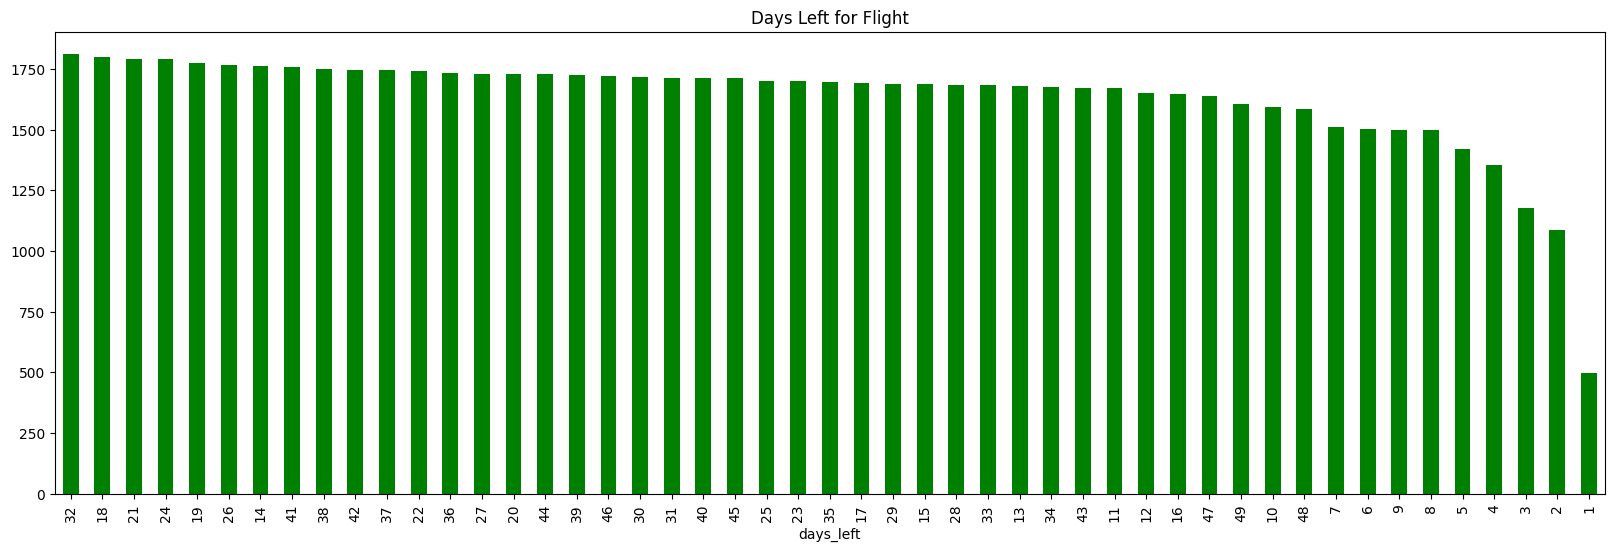

In [9]:
plt.figure(figsize = (20,6))
full_data['days_left'].value_counts().plot(
    kind='bar', title='Days Left for Flight', color='green')

In [10]:
full_data['stops'].value_counts()

stops
one            66935
zero            9522
two_or_more     3543
Name: count, dtype: int64

In [11]:
new_mapping = {'zero': 0, 'one': 1, 'two_or_more': 2}
full_data['no_of_stops'] = full_data['stops'].map(new_mapping)
full_data.drop('stops', axis=1, inplace=True)
full_data

C:\Users\andri\AppData\Local\Temp\ipykernel_20168\2033099100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['no_of_stops'] = full_data['stops'].map(new_mapping)
C:\Users\andri\AppData\Local\Temp\ipykernel_20168\2033099100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data.drop('stops', axis=1, inplace=True)


,airline,source_city,departure_time,arrival_time,destination_city,class,days_left,price,duration_days,duration_hours,duration_mins,no_of_stops
163867,Vistara,Hyderabad,Afternoon,Night,Mumbai,Economy,38,4961,0,10,25,1
236017,Air_India,Mumbai,Morning,Evening,Kolkata,Business,25,49725,0,9,10,1
178706,Indigo,Hyderabad,Evening,Night,Chennai,Economy,30,1788,0,1,15,0
231248,Vistara,Mumbai,Evening,Night,Bangalore,Business,16,62448,0,5,45,1
214203,Air_India,Delhi,Evening,Morning,Bangalore,Business,29,42457,0,17,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...
250822,Vistara,Bangalore,Early_Morning,Evening,Mumbai,Business,26,74956,0,10,40,1
72008,Air_India,Mumbai,Evening,Night,Hyderabad,Economy,14,8096,1,2,0,1
137289,AirAsia,Kolkata,Evening,Evening,Bangalore,Economy,15,6490,0,2,49,0
55074,GO_FIRST,Mumbai,Night,Morning,Bangalore,Economy,15,5102,0,8,55,1


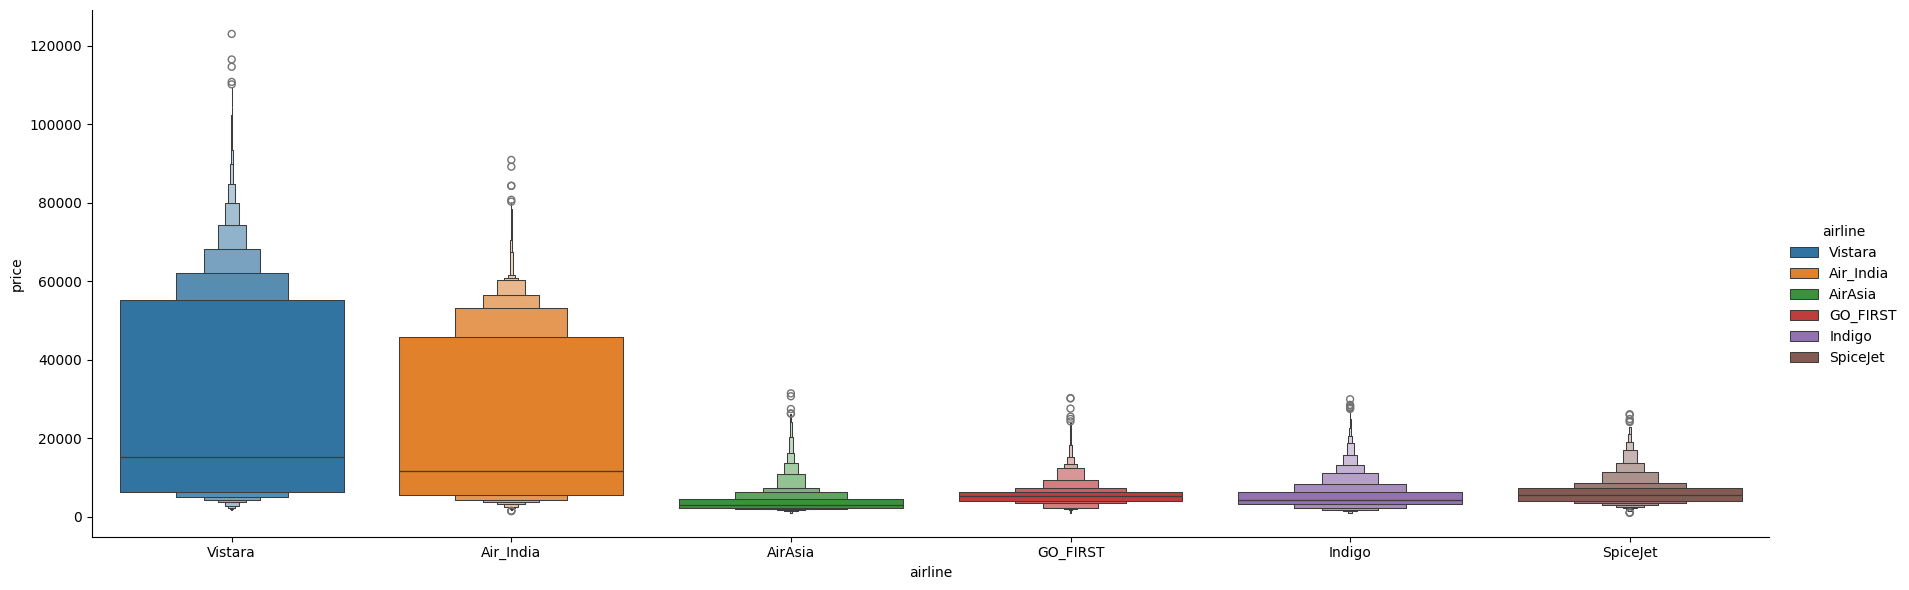

In [12]:
sns.catplot(x='airline',y='price',
            data=full_data.sort_values('price',ascending=False),
            kind='boxen',aspect=3,height=6, hue='airline',
            legend='brief')

In [13]:
airline = full_data[['airline']]
airline = pd.get_dummies(airline, drop_first=False)
airline.head()

,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara
163867,False,False,False,False,False,True
236017,False,True,False,False,False,False
178706,False,False,False,True,False,False
231248,False,False,False,False,False,True
214203,False,True,False,False,False,False


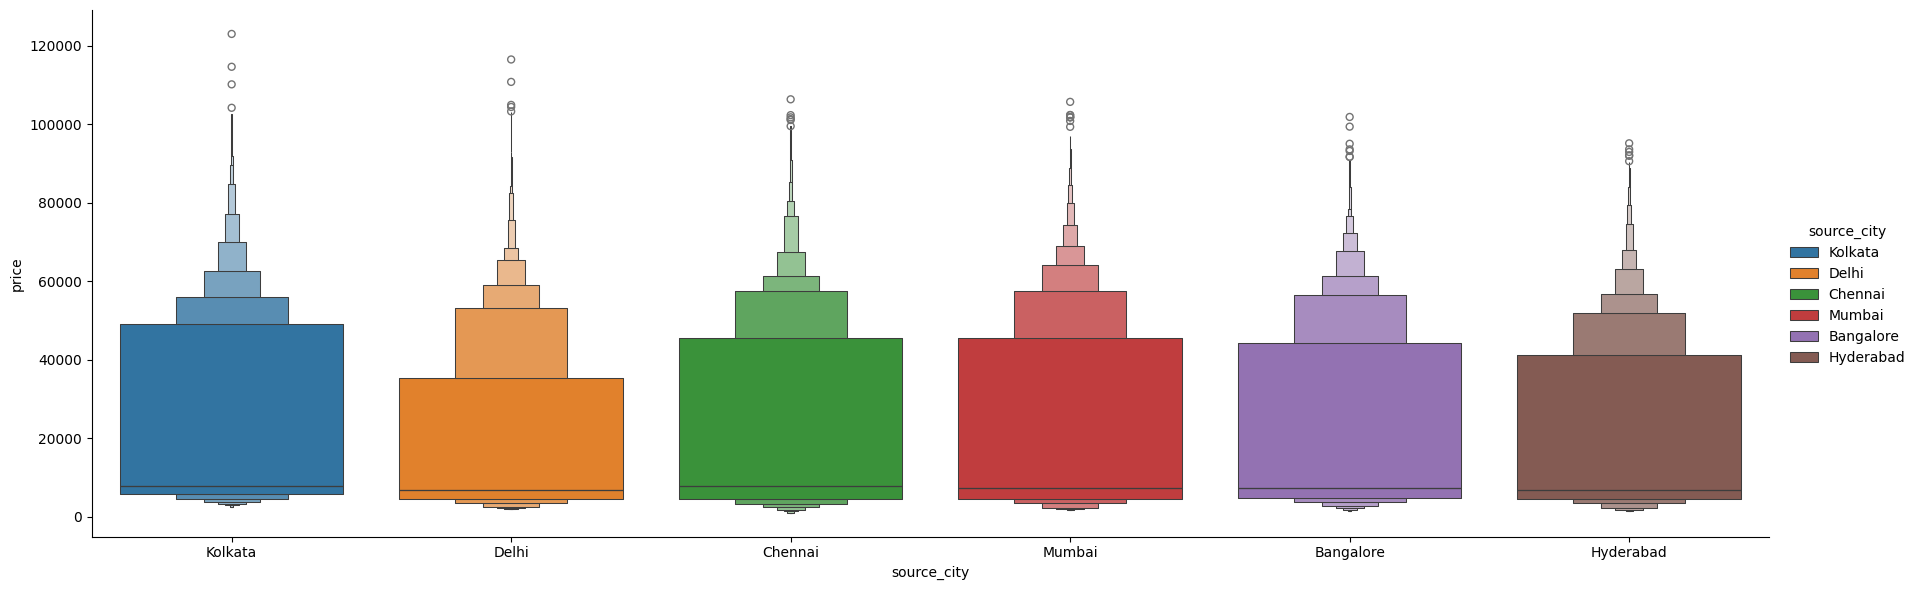

In [14]:
sns.catplot(x='source_city',y='price',
            data=full_data.sort_values('price',ascending=False),
            kind='boxen',aspect=3,height=6, hue='source_city',
            legend='brief')

In [15]:
source = full_data[['source_city']]
source = pd.get_dummies(source, drop_first=False)
source.head()

,source_city_Bangalore,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,source_city_Kolkata,source_city_Mumbai
163867,False,False,False,True,False,False
236017,False,False,False,False,False,True
178706,False,False,False,True,False,False
231248,False,False,False,False,False,True
214203,False,False,True,False,False,False


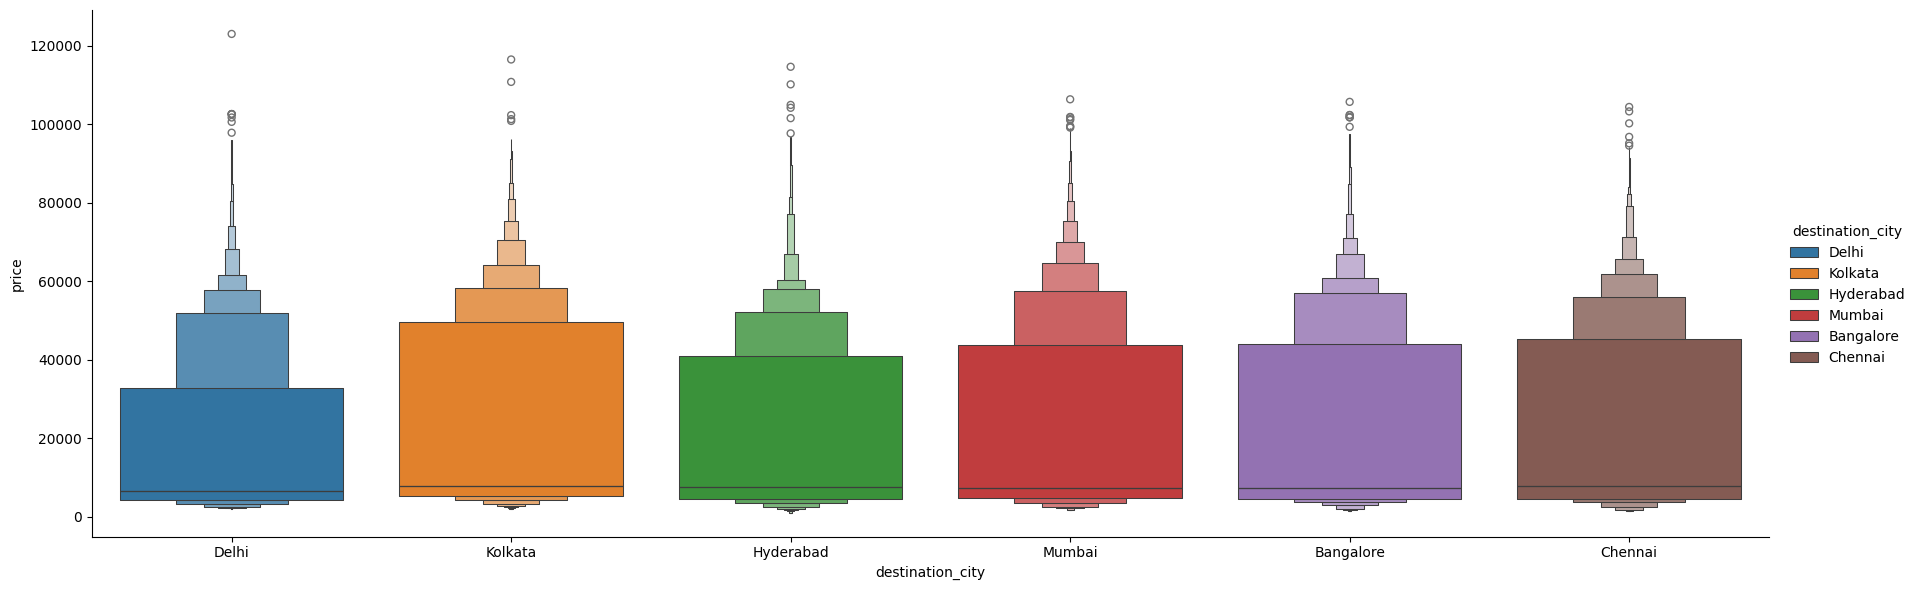

In [16]:
sns.catplot(x='destination_city',y='price',
            data=full_data.sort_values('price',ascending=False),
            kind='boxen',aspect=3,height=6, hue='destination_city',
            legend='brief')

In [17]:
destination = full_data[['destination_city']]
destination = pd.get_dummies(destination, drop_first=False)
destination.head()

,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
163867,False,False,False,False,False,True
236017,False,False,False,False,True,False
178706,False,True,False,False,False,False
231248,True,False,False,False,False,False
214203,True,False,False,False,False,False


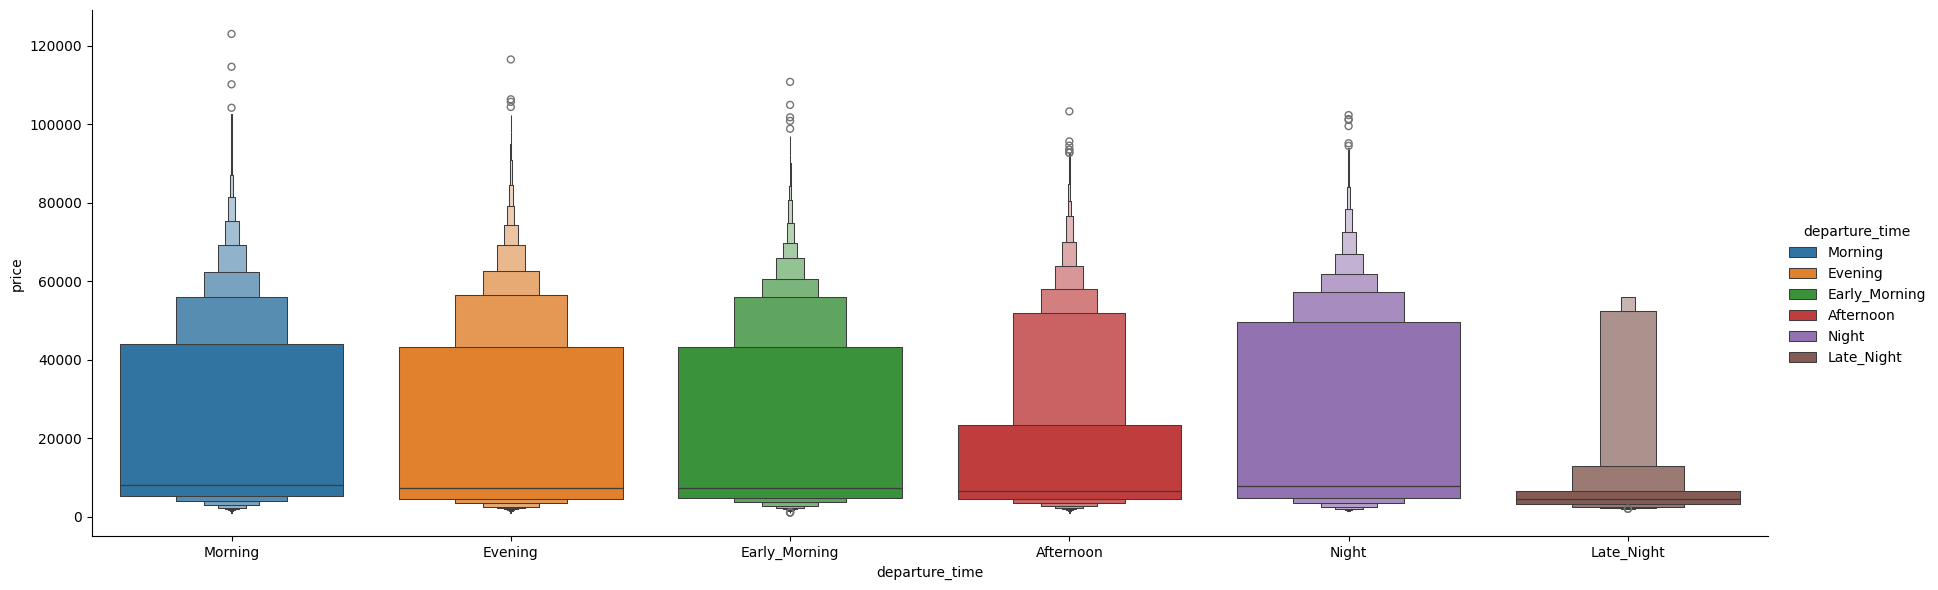

In [18]:
sns.catplot(x='departure_time',y='price',
            data=full_data.sort_values('price',ascending=False),
            kind='boxen',aspect=3,height=6, hue='departure_time',
            legend='brief')

In [19]:
departure = full_data[['departure_time']]
departure = pd.get_dummies(departure, drop_first=False)
departure.head()

,departure_time_Afternoon,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night
163867,True,False,False,False,False,False
236017,False,False,False,False,True,False
178706,False,False,True,False,False,False
231248,False,False,True,False,False,False
214203,False,False,True,False,False,False


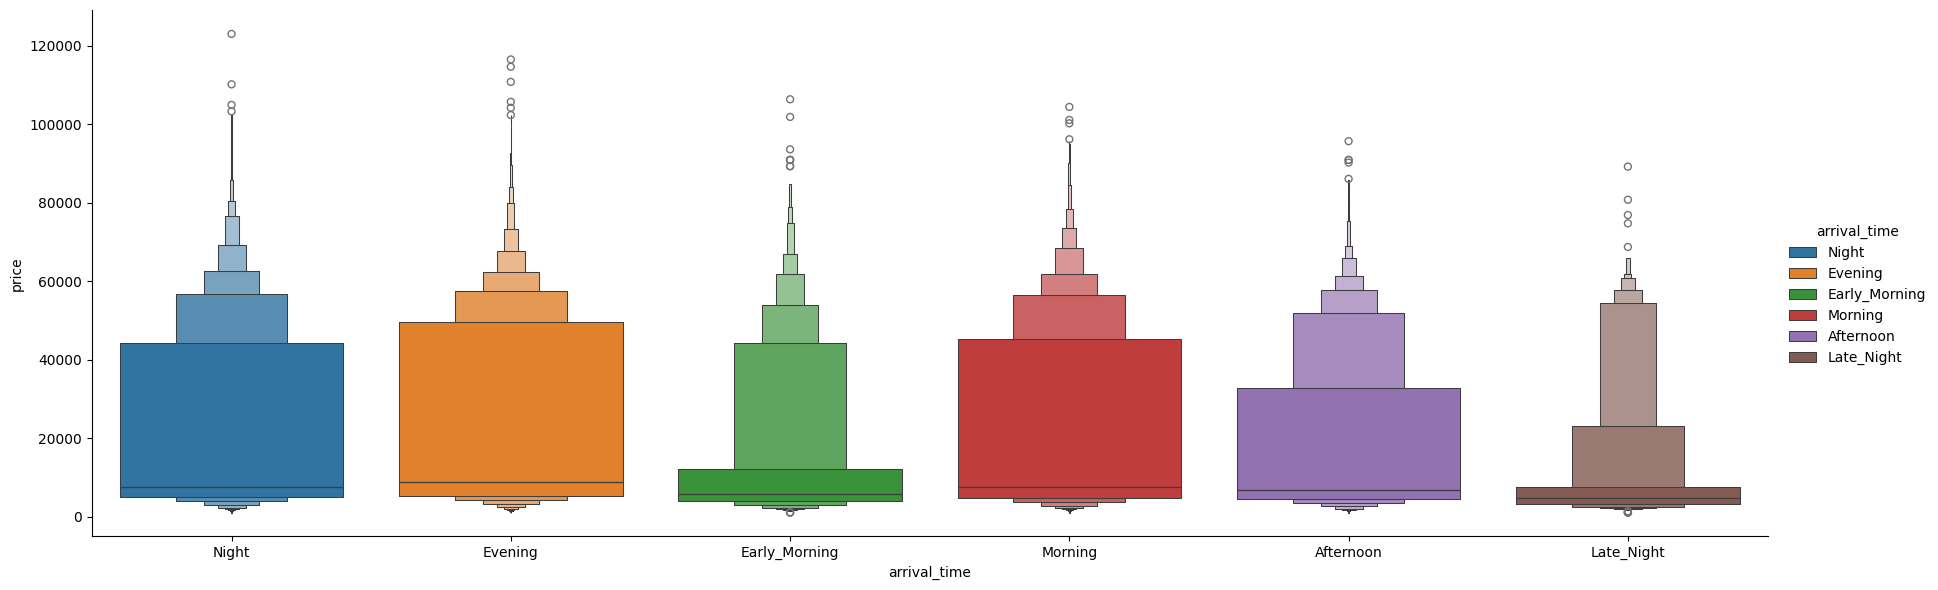

In [20]:
sns.catplot(x='arrival_time',y='price',
            data=full_data.sort_values('price',ascending=False),
            kind='boxen',aspect=3,height=6, hue='arrival_time',
            legend='brief')

In [21]:
arrival = full_data[['arrival_time']]
arrival = pd.get_dummies(arrival, drop_first=False)
arrival.head()

,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
163867,False,False,False,False,False,True
236017,False,False,True,False,False,False
178706,False,False,False,False,False,True
231248,False,False,False,False,False,True
214203,False,False,False,False,True,False


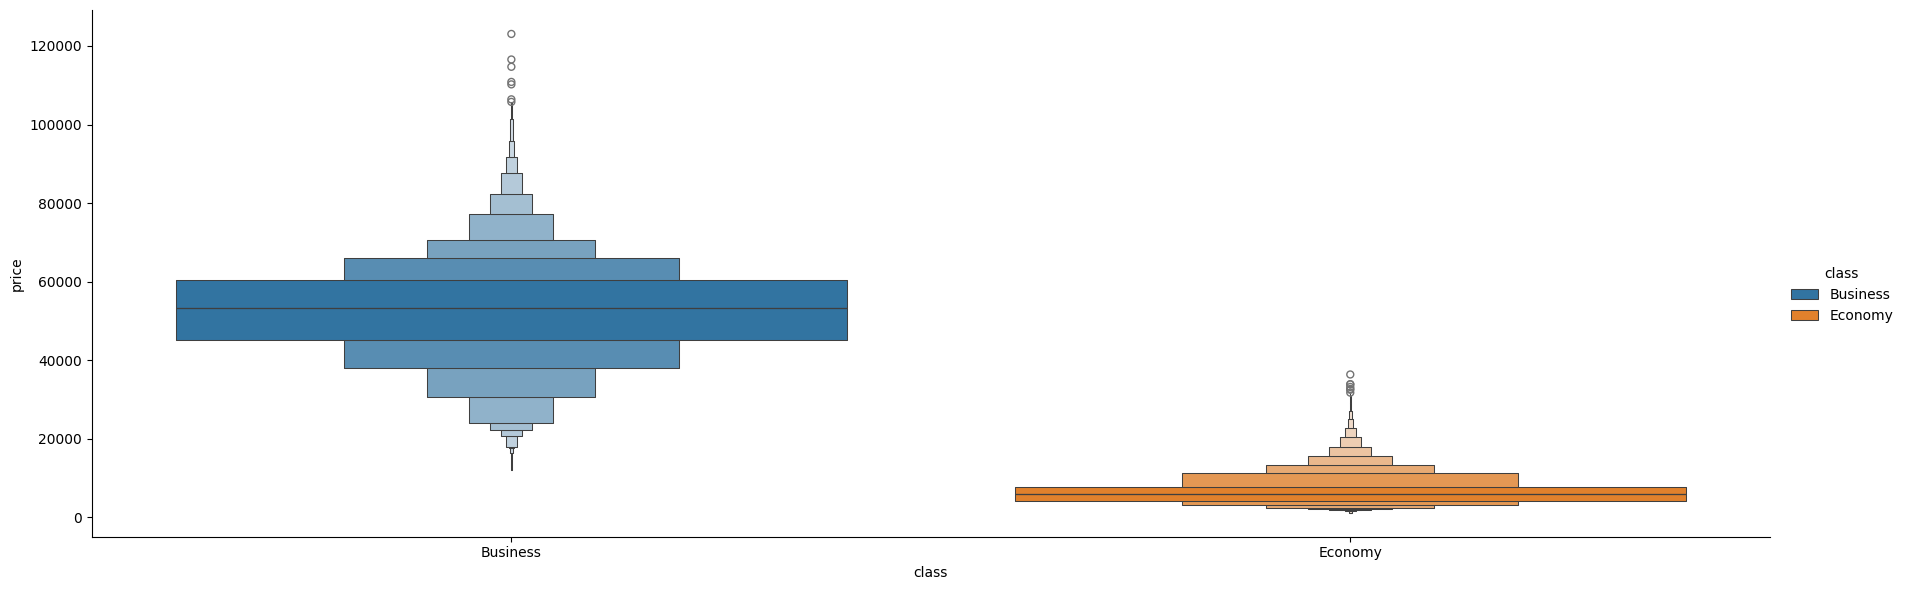

In [22]:
sns.catplot(x='class',y='price',
            data=full_data.sort_values('price',ascending=False),
            kind='boxen',aspect=3,height=6, hue='class',
            legend='brief')

In [23]:
classes = full_data[['class']]
classes = pd.get_dummies(classes, drop_first=False)
classes.head()

,class_Business,class_Economy
163867,False,True
236017,True,False
178706,False,True
231248,True,False
214203,True,False


In [24]:
print(full_data.shape)
print(airline.shape)
print(source.shape)
print(destination.shape)
print(departure.shape)
print(arrival.shape)
print(classes.shape)
# The number of rows in each DataFrame must be the same.

(80000, 12)
(80000, 6)
(80000, 6)
(80000, 6)
(80000, 6)
(80000, 6)
(80000, 2)


In [25]:
data_train = pd.concat(
    [full_data,airline,source,destination,departure,arrival,classes],
    axis = 1)
data_train.drop(
    ['airline','source_city','destination_city',
     'departure_time','arrival_time','class'],
    axis=1, inplace=True)
data_train.head()

,days_left,price,duration_days,duration_hours,duration_mins,no_of_stops,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,...,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,class_Business,class_Economy
163867,38,4961,0,10,25,1,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
236017,25,49725,0,9,10,1,False,True,False,False,...,True,False,False,False,True,False,False,False,True,False
178706,30,1788,0,1,15,0,False,False,False,True,...,False,False,False,False,False,False,False,True,False,True
231248,16,62448,0,5,45,1,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
214203,29,42457,0,17,19,1,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False


In [26]:
# Now take every column apart from 'price'
# and assign it to a variable 'X'.
X = data_train.drop('price',axis=1)
X.head()

,days_left,duration_days,duration_hours,duration_mins,no_of_stops,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,...,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,class_Business,class_Economy
163867,38,0,10,25,1,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
236017,25,0,9,10,1,False,True,False,False,False,...,True,False,False,False,True,False,False,False,True,False
178706,30,0,1,15,0,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
231248,16,0,5,45,1,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
214203,29,0,17,19,1,False,True,False,False,False,...,False,False,False,False,False,False,True,False,True,False


In [27]:
# Take the 'price' column and assign it to a variable 'y'.
y = data_train['price']
y.head()

163867     4961
236017    49725
178706     1788
231248    62448
214203    42457
Name: price, dtype: int64

In [28]:
reg = ExtraTreesRegressor()    # a model for predicting the prices.
reg.fit(X,y)
print(reg.feature_importances_)

[1.86116677e-02 2.43575644e-03 1.18707790e-02 7.62663148e-03
 3.18658909e-02 3.54457419e-04 6.36570257e-03 7.23564145e-05
 2.74475438e-04 5.61955989e-05 4.62391934e-03 9.84658561e-04
 8.55898693e-04 4.13869581e-03 1.48494610e-03 1.94184370e-03
 2.52650468e-03 1.56916156e-03 1.01425613e-03 3.87633256e-03
 1.18227222e-03 2.16650062e-03 1.72156466e-03 1.26443710e-03
 1.08866531e-03 1.59988223e-03 4.84398931e-05 1.09138390e-03
 8.17151568e-04 1.12605591e-03 9.46023633e-04 1.42009801e-03
 1.96551065e-04 8.53797553e-04 1.69598199e-03 3.87301602e-01
 4.92929462e-01]


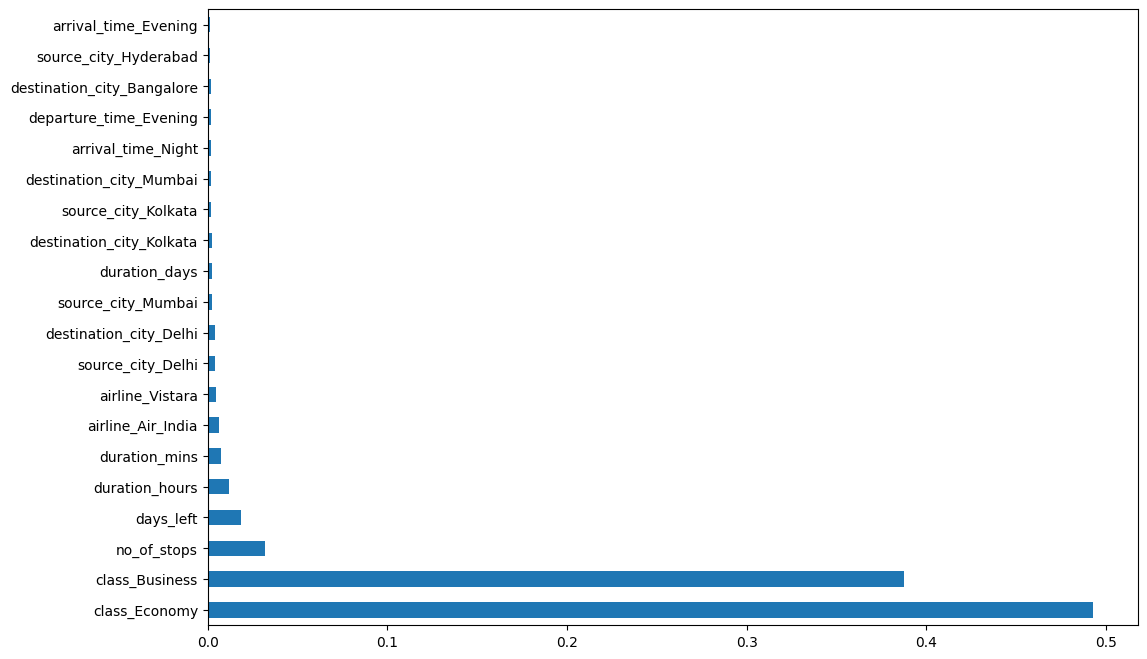

In [29]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42)

In [31]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
# Random search of parameters, using 5 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5, 
                               verbose=1, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\andri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\andri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\andri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\andri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [32]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [33]:
prediction = rf_random.predict(X_test)

C:\Users\andri\AppData\Local\Temp\ipykernel_20168\375150797.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


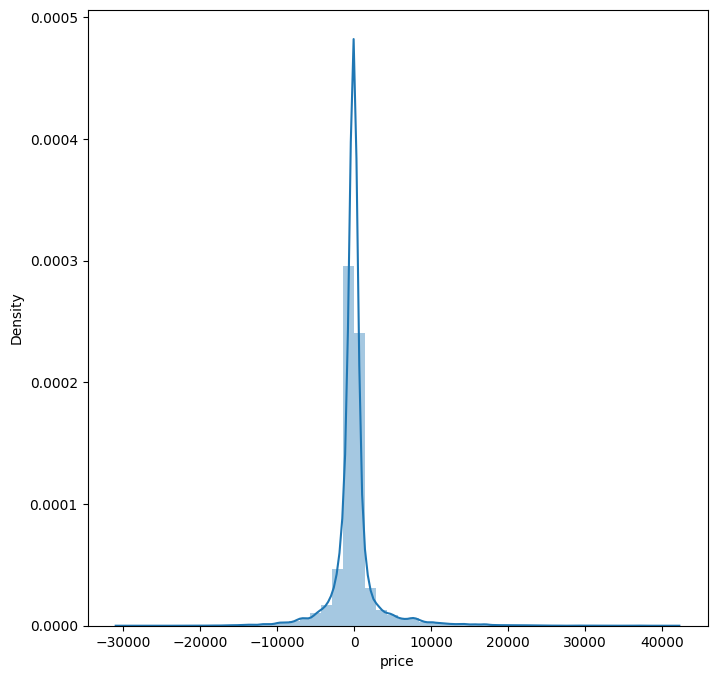

In [34]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

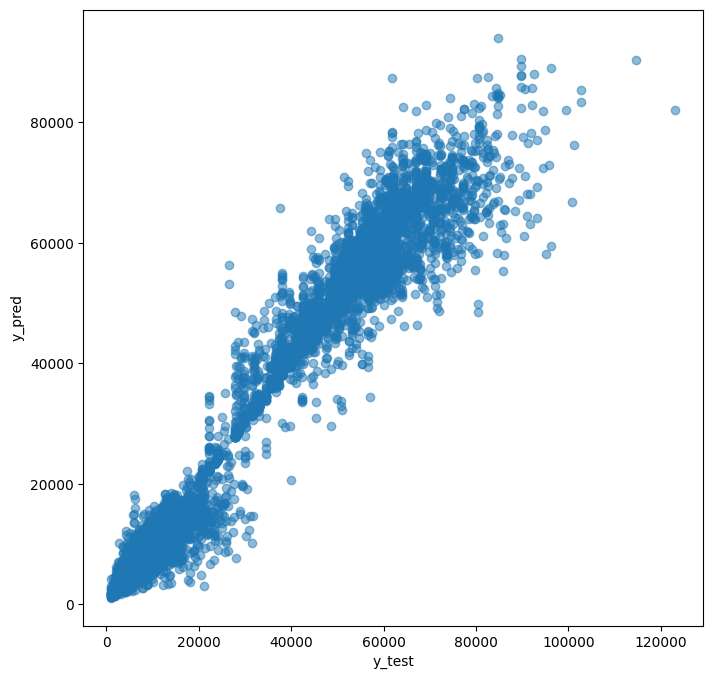

In [35]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [36]:
print('r2 score: ', metrics.r2_score(y_test,prediction))

r2 score:  0.9822782560495772


In [37]:
import gzip
with gzip.open('flight_rf.pkl.gz', 'wb') as file:
    pickle.dump(rf_random, file)
print(".pkl.gz file successfully created!")

.pkl.gz file successfully created!


In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 163867 to 289994
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   days_left                     80000 non-null  int64
 1   duration_days                 80000 non-null  int64
 2   duration_hours                80000 non-null  int64
 3   duration_mins                 80000 non-null  int64
 4   no_of_stops                   80000 non-null  int64
 5   airline_AirAsia               80000 non-null  bool 
 6   airline_Air_India             80000 non-null  bool 
 7   airline_GO_FIRST              80000 non-null  bool 
 8   airline_Indigo                80000 non-null  bool 
 9   airline_SpiceJet              80000 non-null  bool 
 10  airline_Vistara               80000 non-null  bool 
 11  source_city_Bangalore         80000 non-null  bool 
 12  source_city_Chennai           80000 non-null  bool 
 13  source_city_Delhi             